In [1]:
import os
import pandas as pd
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
import spacy
import pickle
import numpy as np
from scipy import sparse
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
%reload_ext autoreload
%autoreload 2

In [2]:
path = '../hw1/data'
TRAINFILE = '1598639150_466036_train_file.txt'
TESTFILE = '1598639150_4984343_test_file.txt'

## Load data into dataframe

In [3]:
train_df = pd.read_csv(os.path.join(path, TRAINFILE), sep="\t", header=0)
test_df = pd.read_fwf(os.path.join(path, TESTFILE), header=None)
test_df = test_df.dropna(axis='columns')
test_df.columns = ['review']

In [4]:
train_df.head()

,sentiment,review
0,1,One of the other reviewers has mentioned that ...
1,1,A wonderful little production. <br /><br />The...
2,1,I thought this was a wonderful way to spend ti...
3,-1,Basically there's a family where a little boy ...
4,1,"Petter Mattei's ""Love in the Time of Money"" is..."


## Text preprocessing function

In [5]:
from afinn import Afinn
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer(language='english')

def preProcess(rawReview, features):
    
    #Html tag
    text_only = BeautifulSoup(rawReview).get_text()
    #
    #Emain and Url
    noEmail = re.sub(r'([\w\.-]+@[\w\.-]+\.\w+)','',text_only)
    
    noUrl = re.sub(r'(?i)\b((?:[a-z][\w-]+:(?:/{1,3}|[a-z0-9%])|www\d{0,3}[.]| \
        [a-z0-9.\-]+[.][a-z]{2,4}/|[a-z0-9.\-]+[.][a-z])(?:[^\s()<>]+|\(([^\s()<>]+| \
        (\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))','', noEmail)
    
    #Emoticons
    smileys = """:-) :) :o) :D :-D :( :-( :o(""".split()
    smileyPattern = "|".join(map(re.escape, smileys))
    
    letters_only = re.sub("[^a-zA-Z" + smileyPattern + "]", " ", noUrl)

    words = letters_only.lower().split()     
    
    doc = nlp(" ".join(words))
    tags=['NOUN', 'ADJ']
    for feature in features:
        if feature == "lemma": 
            words = [token.lemma_ for token in doc if token.pos_ in tags and 
                     token.is_stop is False and len(token)>1]
        if feature =="stem":
            words = [stemmer.stem(token) for token in words]
        
        if feature =="sentiment":
            af = Afinn()
            words = ['neut' if af.score(token)==0 else token for token in words]
                
                
    words = " ".join(words)
    return words


## Function to calculate tf-dif metrices

In [29]:
def createTFIDFMatrices(train_data, test_data, feature =  dict(), use_feature=False):
    if use_feature == True:
        vectorizer = TfidfVectorizer(norm = 'l2',min_df = 0, use_idf = feature['use_idf'], 
                                     smooth_idf = feature['smooth_idf'], 
                                     sublinear_tf = True, \
                                 ngram_range=feature['ngram_range'], max_features = feature['max_f'])
    else:
        vectorizer = TfidfVectorizer(norm = 'l2') 
    train_matrix = vectorizer.fit_transform(train_data)
    test_matrix = vectorizer.transform(test_data)

    return train_matrix, test_matrix

## KNN class

In [7]:
class KNN:
    train_X=0
    train_y=0
    test_X=0
    test_y = 0
    
    def __init__(self, k, dist,select):
        self.neighbour = k
        self.distance = dist
        self.selection = select
        print("# of neighbours: {}, distance: {}, selection_method: {}".format(self.neighbour, 
                                                                             self.distance, 
                                                                             self.selection))

    def fit(self, X,y):
        KNN.train_X = X
        KNN.train_y = y
        
    def findDistances(self): 
        if self.distance == 'cosine':
            cosineSimilarities = np.dot(KNN.test_X, np.transpose(KNN.train_X))
            similarities = cosineSimilarities.toarray()
        return similarities
    
    def predict(self, X):
        KNN.test_X = X
        KNN.test_y = list()
        similarities =  self.findDistances()
        for similarity in similarities:
            pos = 0
            neg = 0
            k_neighbours = np.argsort(-similarity)[:self.neighbour]
            for neigh in k_neighbours:
                if self.selection =='majority_voting':
                    if int(KNN.train_y[neigh]) == 1:
                        pos += 1
                    else:
                        neg += 1
            if pos>neg:
                KNN.test_y.append(1)
            else:
                KNN.test_y.append(-1)
        return np.array(KNN.test_y)

## Evaluation reprot function

In [8]:
def evaluation(y_test, y_pred, target_names, title, print_flag):
    acc = accuracy_score(y_test,y_pred)
    if print_flag!='print_off':
        print(title)
        print('Accuracy: ',acc)
        print(classification_report(y_test,y_pred, target_names=target_names))
    return acc

## Save and load data utility functions

In [9]:
def save_output(items, item):
    if item =="output":
        output = open(os.path.join(path,'output-k-300.txt'), 'w')
        output.writelines( "%s\n" % item for item in items )
        output.close()
    if item =="dataframe_save":
        with open(os.path.join(path, "train_df.pickle"),'wb') as trf:
            pickle.dump(items[0], trf)
        with open(os.path.join(path, "test_df.pickle"),'wb') as tef:
            pickle.dump(items[1], tef)

def load_items():
    with open(os.path.join(path, "train_df.pickle"),'rb') as trf:
        train_df = pickle.load(trf)
    with open(os.path.join(path, "test_df.pickle"),'rb') as tef:
        test_df = pickle.load(tef)
    return train_df, test_df

## Preprocess text and save in dataframe

In [48]:
features = ['lemma','stem']
train_df['preprocessed'] = train_df.apply(lambda row: preProcess(row['review'],features),axis=1) 
test_df['preprocessed'] = test_df.apply(lambda row: preProcess(row['review'],features),axis=1)
save_output([train_df, test_df], 'dataframe_save')

In [10]:
train_df, test_df = load_items()
train_df.head(5)

,sentiment,review,preprocessed
0,1,One of the other reviewers has mentioned that ...,review episod right thing brutal scene violenc...
1,1,A wonderful little production. <br /><br />The...,wonder littl product film techniqu unassuming-...
2,1,I thought this was a wonderful way to spend ti...,wonder way time hot summer weekend air theater...
3,-1,Basically there's a family where a little boy ...,famili littl boy jake zombi closet parent movi...
4,1,"Petter Mattei's ""Love in the Time of Money"" is...",love time money stun film vivid portrait human...


## Finding optimal k value using 5-fold cross validation

In [22]:
max_acc =0
k_acc = {}
for neigh in range(50,500,50):
    knn = KNN(neigh,'cosine','majority_voting')

    split = 5
    kf = KFold(n_splits=split, shuffle= True)
    acc_avg = 0
    acc = 0
    for train_index, test_index in kf.split(train_df):
        X_train, X_test = createTFIDFMatrices(train_df.loc[train_index,'preprocessed'], 
                                             train_df.loc[test_index,'preprocessed'])
        y = train_df['sentiment'].values
        y_train, y_test = y[train_index], y[test_index]
# #         print("train shape:{}, test shape:{}".format(X_train.shape, X_test.shape))
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        acc += evaluation(y_test, y_pred,['-1','1'], 'Classification report (knn):', 'print_off')

    acc_avg = acc/split
    if acc_avg > max_acc:
        max_acc = acc_avg
        optimal_neighbour = neigh
    k_acc[neigh]=acc_avg
    print('Average accuracy: {}'.format(acc_avg), end='\n\n')

print("Optimal neighbour count: {}, max_accuracy achieved: {}".format(optimal_neighbour, max_acc))    

# of neighbours: 50, distance: cosine, selection_method: majority_voting
Average accuracy: 0.7769847282427476

# of neighbours: 100, distance: cosine, selection_method: majority_voting
Average accuracy: 0.7941184617094587

# of neighbours: 150, distance: cosine, selection_method: majority_voting
Average accuracy: 0.8013197287984883

# of neighbours: 200, distance: cosine, selection_method: majority_voting
Average accuracy: 0.8032538846282093

# of neighbours: 250, distance: cosine, selection_method: majority_voting
Average accuracy: 0.8051869067466934

# of neighbours: 300, distance: cosine, selection_method: majority_voting
Average accuracy: 0.8079207069023008

# of neighbours: 350, distance: cosine, selection_method: majority_voting
Average accuracy: 0.8051198177170168

# of neighbours: 400, distance: cosine, selection_method: majority_voting
Average accuracy: 0.8089218183839059

# of neighbours: 450, distance: cosine, selection_method: majority_voting
Average accuracy: 0.80658628431

## Ploting K vs Average accuracy

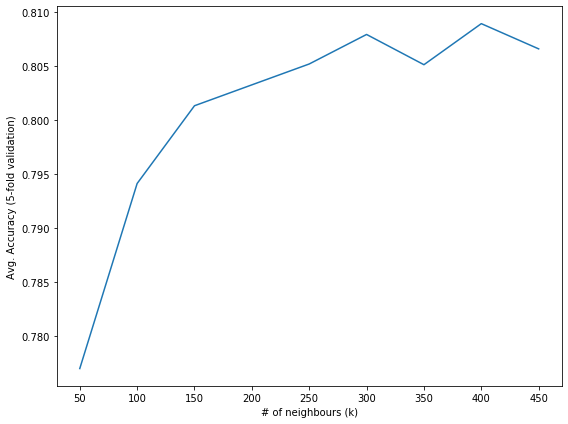

In [37]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.plot(list(k_acc.keys()),list(k_acc.values()))
plt.xlabel("# of neighbours (k)")
plt.ylabel("Avg. Accuracy (5-fold validation)")
plt.tight_layout()
plt.savefig("knn.pdf")

## Finding optimal tf idf parameters on previously found best K value

In [31]:
X_train_df, X_test_df, y_train, y_test = train_test_split(train_df.iloc[:,1:], train_df['sentiment'].values, 
                                                    test_size=0.30, random_state=42)

# norm = 'l2',min_df = 0, use_idf = True, smooth_idf = False, 
#                                  sublinear_tf = True, \
#                              ngram_range=(1,2), max_features = 9000

tfidf_best = {}
max_acc = 0
for max_feature in range(5000, 22000, 3000):
    for use_idf in [True, False]:
        for smooth_idf in [True, False]:
            for ngram_range in [(1,1), (1,2), (2,2)]:
                features = {'max_f': max_feature,
                           'use_idf': use_idf,
                           'smooth_idf': smooth_idf,
                           'ngram_range': ngram_range}
                X_train, X_test = createTFIDFMatrices(X_train_df['preprocessed'], X_test_df['preprocessed'], 
                                                      features, True)
# # X_train, X_test = senti_multiply(X_train_df, X_test_df, X_train, X_test)

                knn = KNN(optimal_neighbour,'cosine','majority_voting')
                knn.fit(X_train, y_train)
                y_pred = knn.predict(X_test)
                acc = evaluation(y_test, y_pred,['-1','1'], 'Classification report (knn):', 'print_off')
                if acc>max_acc:
                    max_acc = acc
                    tfidf_best = features
                print(features , acc)

# of neighbours: 400, distance: cosine, selection_method: majority_voting
{'max_f': 5000, 'use_idf': True, 'smooth_idf': True, 'ngram_range': (1, 1)} 0.8284444444444444
# of neighbours: 400, distance: cosine, selection_method: majority_voting
{'max_f': 5000, 'use_idf': True, 'smooth_idf': True, 'ngram_range': (1, 2)} 0.8251111111111111
# of neighbours: 400, distance: cosine, selection_method: majority_voting
{'max_f': 5000, 'use_idf': True, 'smooth_idf': True, 'ngram_range': (2, 2)} 0.7228888888888889
# of neighbours: 400, distance: cosine, selection_method: majority_voting
{'max_f': 5000, 'use_idf': True, 'smooth_idf': False, 'ngram_range': (1, 1)} 0.8282222222222222
# of neighbours: 400, distance: cosine, selection_method: majority_voting
{'max_f': 5000, 'use_idf': True, 'smooth_idf': False, 'ngram_range': (1, 2)} 0.8242222222222222
# of neighbours: 400, distance: cosine, selection_method: majority_voting
{'max_f': 5000, 'use_idf': True, 'smooth_idf': False, 'ngram_range': (2, 2)} 0.

# of neighbours: 400, distance: cosine, selection_method: majority_voting
{'max_f': 17000, 'use_idf': True, 'smooth_idf': True, 'ngram_range': (1, 2)} 0.8311111111111111
# of neighbours: 400, distance: cosine, selection_method: majority_voting
{'max_f': 17000, 'use_idf': True, 'smooth_idf': True, 'ngram_range': (2, 2)} 0.7364444444444445
# of neighbours: 400, distance: cosine, selection_method: majority_voting
{'max_f': 17000, 'use_idf': True, 'smooth_idf': False, 'ngram_range': (1, 1)} 0.83
# of neighbours: 400, distance: cosine, selection_method: majority_voting
{'max_f': 17000, 'use_idf': True, 'smooth_idf': False, 'ngram_range': (1, 2)} 0.8311111111111111
# of neighbours: 400, distance: cosine, selection_method: majority_voting
{'max_f': 17000, 'use_idf': True, 'smooth_idf': False, 'ngram_range': (2, 2)} 0.736
# of neighbours: 400, distance: cosine, selection_method: majority_voting
{'max_f': 17000, 'use_idf': False, 'smooth_idf': True, 'ngram_range': (1, 1)} 0.7822222222222223
# o

In [32]:
tfidf_best

{'max_f': 20000, 'use_idf': True, 'smooth_idf': False, 'ngram_range': (1, 1)}

## Save the final model output

In [33]:
X_train, X_test = createTFIDFMatrices(train_df['preprocessed'], test_df['preprocessed'], tfidf_best, True)
y_train = train_df['sentiment'].values
knn = KNN(optimal_neighbour,'cosine','majority_voting')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
y_pred = ['-1' if y==-1 else '+1' for y in y_pred]

save_output(y_pred,'output')

# of neighbours: 400, distance: cosine, selection_method: majority_voting
